# Super Resolution

In [3]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch.nn as nn
import torch
import torchvision.transforms.v2 as transforms
from torchinfo import summary
from lightning import Trainer
from lightning.pytorch.tuner.tuning import Tuner

from nimrod.image.datasets import ImageDataset, ImageDataModule, ImageSuperResDataModule, ImageSuperResDataset
from nimrod.models.core import lr_finder, train_one_cycle, Regressor
from nimrod.models.resnet import ResBlock
from nimrod.utils import get_device, set_seed
from nimrod.models.superres import SuperResAutoencoder, SuperResAutoencoderX, UpBlock

from hydra.utils import instantiate
from omegaconf import OmegaConf
from rich import print
from typing import Optional, Type, List, Callable, Any
import matplotlib.pyplot as plt
from functools import partial
import logging

set_seed(42)
logger = logging.getLogger(__name__)
device = get_device()

Seed set to 42
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Seed set to 42
Seed set to 42
Seed set to 42
[23:17:33] INFO - Using device: mps
Seed set to 42
[23:17:33] INFO - Using device: mps


## Data

In [8]:
#| notest

%time
# data
cfg = OmegaConf.load('../config/data/image/tiny_imagenet_superres.yaml')
cfg.batch_size = 512
dm = instantiate(cfg)
dm.prepare_data()
dm.setup()

[23:22:21] INFO - Init ImageSuperResDataModule for slegroux/tiny-imagenet-200-clean
[23:22:21] INFO - Init ImageDataModule for slegroux/tiny-imagenet-200-clean


CPU times: user 3 μs, sys: 1 μs, total: 4 μs
Wall time: 4.77 μs


[23:22:26] INFO - loading dataset slegroux/tiny-imagenet-200-clean with args () from split train
[23:22:26] INFO - loading dataset slegroux/tiny-imagenet-200-clean from split train
Overwrite dataset info from restored data version if exists.
[23:22:28] INFO - Overwrite dataset info from restored data version if exists.
Loading Dataset info from ../data/image/slegroux___tiny-imagenet-200-clean/default/0.0.0/4b908d89fab3eb36aa8ebcd41c1996b28da7d6f2
[23:22:28] INFO - Loading Dataset info from ../data/image/slegroux___tiny-imagenet-200-clean/default/0.0.0/4b908d89fab3eb36aa8ebcd41c1996b28da7d6f2
Found cached dataset tiny-imagenet-200-clean (/Users/slegroux/Projects/nimrod/tutorials/../data/image/slegroux___tiny-imagenet-200-clean/default/0.0.0/4b908d89fab3eb36aa8ebcd41c1996b28da7d6f2)
[23:22:28] INFO - Found cached dataset tiny-imagenet-200-clean (/Users/slegroux/Projects/nimrod/tutorials/../data/image/slegroux___tiny-imagenet-200-clean/default/0.0.0/4b908d89fab3eb36aa8ebcd41c1996b28da7d6f

## Model

In [9]:
# model
model = SuperResAutoencoder(n_features=[3, 8, 16, 32, 64, 128, 256]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [7]:
n_epochs = 1
losses = []
lrs = []
current_step = 0
total_steps = len(dm.train_dataloader()) * n_epochs
print(f"total_steps: {total_steps}")

for epoch in range(n_epochs):
    model.train()
    for low_res, high_res in dm.train_dataloader():

        optimizer.zero_grad()
        low_res = low_res.to(device)
        high_res = high_res.to(device)
        outputs = model(low_res)
        loss = criterion(outputs, high_res)        
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        current_lr = optimizer.param_groups[0]['lr']
        lrs.append(current_lr)
        current_step += 1

    print(f"Epoch {epoch + 1}: Training Loss {loss.item():.4f}, Current LR: {current_lr:.10f}, Step: {current_step}/{total_steps}")
        

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for low_res, high_res in dm.test_dataloader():
            # model expects input (B,H*W)
            low_res = low_res.to(device)
            low_res = low_res.to(device)
            high_res = high_res.to(device)
            # Pass the input through the model
            outputs = model(low_res)
            val_loss = criterion(outputs, high_res)
    print(f"Epoch {epoch + 1}: Validation Loss {val_loss.item():.4f}")


total_steps: 48

Loss 2.4260, Current LR: 0.0003000000, Step: 0/48

Loss 1.7441, Current LR: 0.0003000000, Step: 1/48

Loss 1.5152, Current LR: 0.0003000000, Step: 2/48

KeyboardInterrupt: 

## Test

In [39]:
x = dm.train_ds[0][0].unsqueeze(0).to(device)
y_hat = model(x)
y_hat.shape

torch.Size([1, 3, 64, 64])

In [44]:
x_mean = torch.tensor([0.4822, 0.4495, 0.3985])
x_std = torch.tensor([0.2771, 0.2690, 0.2826])

tfm_norm = transforms.Normalize(mean=x_mean, std=x_std)
tfm_denorm = transforms.Compose([transforms.Normalize(mean=[0,0,0], std=1/x_std), transforms.Normalize(mean=-x_mean, std=[1,1,1])])


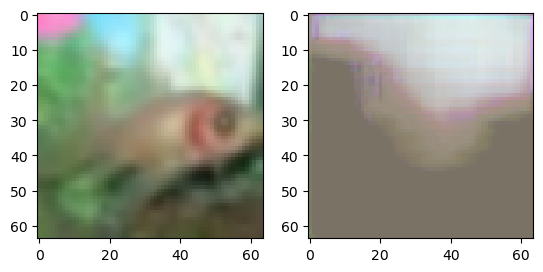

In [45]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(tfm_denorm(x[0]).permute(1, 2, 0).cpu().numpy())
ax[1].imshow(tfm_denorm(y_hat[0]).permute(1, 2, 0).detach().cpu().numpy())

## SuperResAutoencoderX

In [77]:
optimizer = partial(torch.optim.AdamW, lr=1e-3, weight_decay=1e-5)
scheduler = partial(torch.optim.lr_scheduler.ReduceLROnPlateau, mode='min', factor=0.1, patience=10)

model = SuperResAutoencoderX(
    nnet=SuperResAutoencoder(),
    optimizer=optimizer,
    scheduler=scheduler
    )

[17:26:27] INFO - SuperResAutoencoderX: init
[17:26:27] INFO - Regressor: init
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'nnet' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['nnet'])`.


In [81]:
print(optimizer.keywords.get('lr'))

0.001

In [66]:
summary(model.hparams.nnet, input_size=(1, 3, 64, 64), depth=2)

Layer (type:depth-idx)                                       Output Shape              Param #
SuperResAutoencoder                                          [1, 3, 64, 64]            --
├─Sequential: 1-1                                            [1, 3, 64, 64]            --
│    └─ResBlock: 2-1                                         [1, 8, 64, 64]            864
│    └─ResBlock: 2-2                                         [1, 16, 32, 32]           3,680
│    └─ResBlock: 2-3                                         [1, 32, 16, 16]           14,528
│    └─ResBlock: 2-4                                         [1, 64, 8, 8]             57,728
│    └─ResBlock: 2-5                                         [1, 128, 4, 4]            230,144
│    └─UpBlock: 2-6                                          [1, 64, 8, 8]             119,168
│    └─UpBlock: 2-7                                          [1, 32, 16, 16]           29,888
│    └─UpBlock: 2-8                                          [1, 16, 

In [78]:
trainer = Trainer(accelerator="auto")
tuner  = Tuner(trainer)
lr_finder = tuner.lr_find(
    model,
    datamodule=dm,
    min_lr=1e-5,
    max_lr=1.0,
    num_training=100,  # number of iterations
    # attr_name="optimizer.lr",
)

fig = lr_finder.plot(suggest=True)
plt.show()
print(f"Suggested learning rate: {lr_finder.suggestion()}")



GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
[17:27:06] INFO - loading dataset slegroux/tiny-imagenet-200-clean with args () from split train
[17:27:06] INFO - loading dataset slegroux/tiny-imagenet-200-clean from split train
Overwrite dataset info from restored data version if exists.
[17:27:09] INFO - Overwrite dataset info from restored data version if exists.
Loading Dataset info from ../data/image/slegroux___tiny-imagenet-200-clean/default/0.0.0/4b908d89fab3eb36aa8ebcd41c1996b28da7d6f2
[17:27:09] INFO - Loading Dataset info from ../data/image/slegroux___tiny-imagenet-200-clean/default/0.0.0/4b908d89fab3eb36aa8ebcd41c1996b28da7d6f2
Found cached dataset tiny-imagenet-200-clean (/Users/slegroux/Projects

ValueError: optimizer got an empty parameter list